## Model selection 

Librairies

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import re
import sklearn
import random
import textdistance
import umap

from sklearn.tree              import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from transformers              import BertTokenizer, BertModel
from sentence_transformers     import SentenceTransformer
from sklearn.metrics           import roc_curve
from umap                      import UMAP
from typing                    import Optional
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\a.tekiouk\AppData\Local\Programs\Py

Import data

In [2]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
ENCODER_ID = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(ENCODER_ID)
X = encoder.encode(chanel_junk_valid_new['text'])
y = chanel_junk_valid_new['is_junk']

Selection

In [3]:
def fit_params(
    X: pd.DataFrame,
    y: pd.Series,
    grid_params: dict,
    predictor = DecisionTreeClassifier(),
    hyperopt_params: Optional[dict] = None,
)-> dict:
    """
    Fits a given model on the provided dataset after reducing dimensions with the provided reducer.

    Parameters
    ----------
    X : pd.DataFrame
        The input DataFrame containing the features.
    y : pd.Series
        The target variable.
    grid_params : dict
        The dictionary of hyperparameter grids to search over using GridSearchCV.
    predictor : object, optional
        The model object implementing the scikit-learn estimator interface, by default DecisionTreeClassifier().
    hyperopt_params : dict, optional
        Additional parameters to be passed to the GridSearchCV for hyperparameter optimization, by default None.

    Returns
    -------
    dict
        The best parameters found by the hyperparameter optimization.
    """
    if hyperopt_params is None:
        hyperopt_params = {}
    
    # perform hyperopt with model on reduced data
    return (
        GridSearchCV(
            estimator=predictor,
            param_grid=grid_params,
            **hyperopt_params
        )
        .fit(X, y)
        .best_params_
    )
    

In [4]:
def auto_model_selection(
    X : pd.Series,
    y : pd.Series,
    dimension_range : range
    )-> tuple[object, float, int]:
    """
    Automatically selects the best model using dimensionality reduction techniques (PCA, UMAP)
    and evaluates their performance based on ROC AUC score.

    Parameters
    ----------
    X : pd.Series
        The input feature data.
    y : pd.Series
        The target variable.
    dimension_range : range
        The range of dimensions to explore for dimensionality reduction.

    Returns
    -------
    Tuple[object, float, int]
        A tuple containing the best model, the best ROC AUC score, and the optimal number of dimensions.
    """
    best_auc= 0
    # PCA DecisionTree
    for dim in dimension_range:
        reducer = PCA(n_components=dim)
        predictor = DecisionTreeClassifier(random_state = 42)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'criterion': ['entropy', 'gini', 'log_loss'],
                'max_depth' : np.arange(2, 6, dtype=int),
                'ccp_alpha' : np.linspace(0.0, 0.20, 5)
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            reducer = reducer

    # UMAP DecisionTree
    for dim in dimension_range:
        reducer = UMAP(n_components=dim)
        predictor = DecisionTreeClassifier(random_state = 42)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'criterion': ['entropy', 'gini', 'log_loss'],
                'max_depth' : np.arange(2, 6, dtype=int),
                'ccp_alpha' : np.linspace(0.0, 0.20, 5)
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            reducer = reducer
            
    # PCA Logistic Regression
    for dim in dimension_range:
        reducer = PCA(n_components=dim)
        predictor = LogisticRegression(random_state = 42,max_iter=1000)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'solver': ['lbfgs', 'liblinear', 'newton-cg','newton-cholesky','sag','saga']
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            reducer = reducer
            
    # UMAP Logistic Regression
    for dim in dimension_range:
        reducer = UMAP(n_components=dim)
        predictor = LogisticRegression(random_state = 42,max_iter=1000)
        X_reduced = reducer.fit(X).transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
        opt_params = fit_params(
            X=X_train,
            y=y_train,
            predictor=predictor,
            grid_params={
                'solver': ['lbfgs', 'liblinear', 'newton-cg','newton-cholesky','sag','saga']
            },
            hyperopt_params={
                "scoring": "roc_auc",
                "cv": 5,
                "refit": True
            })
        model = predictor.set_params(**opt_params).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
        auc = metrics.auc(fpr, tpr)
        if(auc>best_auc):
            best_auc = auc
            best_model = model
            opt_nb_dim = dim
            reducer = reducer
            
    return best_model,best_auc,opt_nb_dim,reducer

In [5]:
def evaluate(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_score: pd.Series,
) -> None:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
    print(f"AUC : {metrics.auc(fpr, tpr):.3f}")
    print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred):.3f}")
    print(f"Precision score : {metrics.precision_score(y_test, y_pred):.3f}")
    print(f"Recall score : {metrics.recall_score(y_test, y_pred):.3f}")
    utilities.plot_confusion_matrix(y_true=y_test, y_pred=y_pred)

In [6]:
best_model_auc,best_auc,opt_dim,reducer = auto_model_selection(
    X=X,
    y=y,
    dimension_range=range(10,350))
best_model_auc,best_auc,opt_dim,reducer

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_glm\_newton_solver.py:491: LinAlgWarning: The inner s

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\o

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


(LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
 0.9380370872908186,
 59,
 UMAP(n_components=349, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))

**model** :LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')  
**dimensions** : UMAP(59)

AUC : 0.890
Accuracy score : 0.820
Precision score : 0.714
Recall score : 0.758


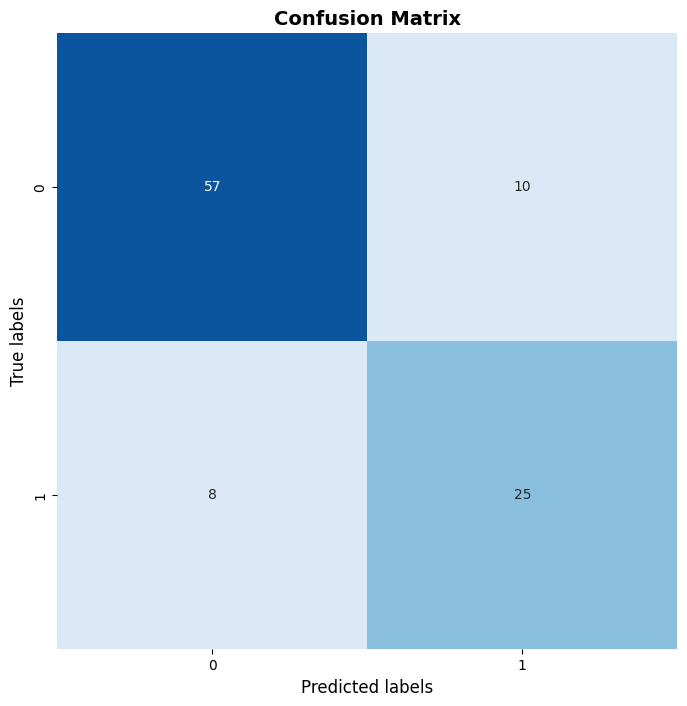

In [8]:
X_reduced =  UMAP(n_components=59).fit(X).transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_reduced,y, test_size=0.2, random_state=42)
model_lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear').fit(X_train,y_train)
evaluate(y_test, 
         model_lr.predict(X_test), 
         model_lr.predict_proba(X_test)[:, 1])

Optimization using precision

In [59]:
metrics.recall_score(y_test, model_lr.predict(X_test))

0.7575757575757576

In [30]:
threshold = 0.50
y_p2 = model_lr.predict(X_train)
y_score = model_lr.predict_proba(X_train)
print(f"Recall : {metrics.recall_score(y_train, model_lr.predict(X_train))}")
print(f"Precision : {metrics.precision_score(y_train, model_lr.predict(X_train))}")
while (metrics.recall_score(y_train, y_p2)>0.65):
    threshold = threshold+0.01
    y_p2 = np.where(y_score[:, 1] > threshold, 1, 0)

print(f"Threshold : {threshold}")
print(f"Recall : {metrics.recall_score(y_train, y_p2)}")
print(f"Precision : {metrics.precision_score(y_train, y_p2)}")

Recall : 0.7529411764705882
Precision : 0.7619047619047619
Threshold : 0.6200000000000001
Recall : 0.6470588235294118
Precision : 0.8527131782945736


Threshhold proba : 0.62

AUC : 0.890
Accuracy score : 0.870
Precision score : 0.917
Recall score : 0.667


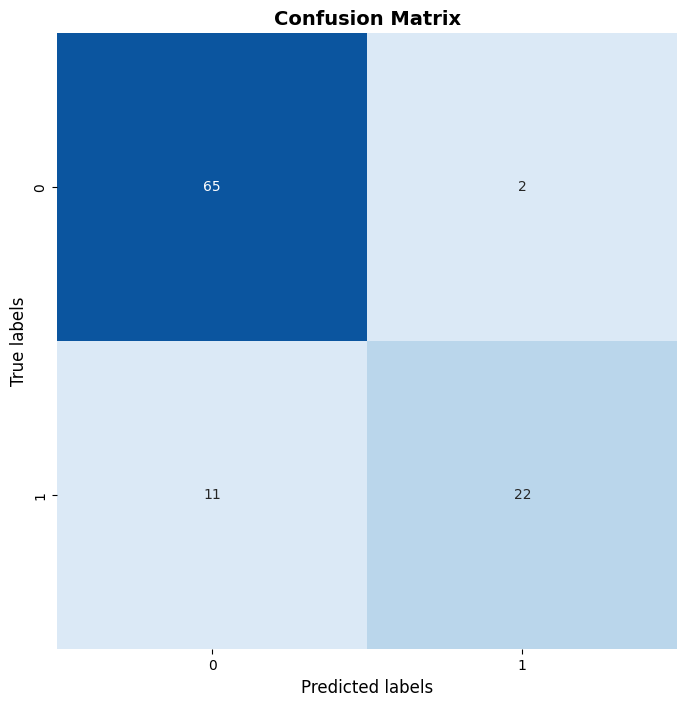

In [31]:
y_p_f = np.where(model_lr.predict_proba(X_test)[:, 1] > 0.62, 1, 0)
evaluate(y_test,y_p_f,model_lr.predict_proba(X_test)[:, 1])

In [48]:
model_lr.classes_
#array([0, 1], dtype=int64)

array([0, 1], dtype=int64)

In [117]:
model_lr.intercept_
#array([0.0027804])

array([0.0027804])

In [27]:
model_lr.coef_
# array([[ 6.62164206e-01,  5.03002157e-01, -4.53304304e-01,
#          2.68181250e-01, -9.47251685e-01, -6.28021903e-01,
#         -4.72567074e-01, -2.82974499e-01, -3.33617556e-02,
#         -1.29527265e-01, -1.55892094e-01,  1.73115524e-01,
#         -1.01486380e-01,  3.93124635e-01,  6.39108089e-01,
#          8.76922769e-02, -2.93340540e-02, -2.74243687e-04,
#          1.61420319e-01, -5.05814477e-01,  2.41851756e-01,
#          2.61812449e-02,  2.60183574e-01,  7.00366584e-01,
#          1.89293688e-02,  1.77294659e-01,  5.50157464e-01,
#          2.87141867e-02,  7.39068894e-02, -1.78634103e-02,
#         -6.87467820e-01,  4.10424805e-01, -4.10558257e-01,
#          2.08970009e-01, -1.50035663e-01,  2.42750768e-01,
#         -6.58186225e-01, -3.79276718e-02, -2.93772071e-01,
#         -5.51559764e-01,  1.83408576e-01, -3.73097423e-02,
#          4.47509167e-01,  7.91106267e-01,  1.90731048e-01,
#          8.67583755e-02,  4.85110863e-01, -2.98993095e-01,
#         -4.41818024e-01,  7.69862304e-02, -3.78937983e-01,
#          7.33489626e-02,  1.67710043e-01, -2.24204432e-01,
#         -7.25897288e-02,  6.50244324e-02, -3.70098248e-01,
#          4.76028054e-01, -3.58921034e-01]])

array([[ 6.62164206e-01,  5.03002157e-01, -4.53304304e-01,
         2.68181250e-01, -9.47251685e-01, -6.28021903e-01,
        -4.72567074e-01, -2.82974499e-01, -3.33617556e-02,
        -1.29527265e-01, -1.55892094e-01,  1.73115524e-01,
        -1.01486380e-01,  3.93124635e-01,  6.39108089e-01,
         8.76922769e-02, -2.93340540e-02, -2.74243687e-04,
         1.61420319e-01, -5.05814477e-01,  2.41851756e-01,
         2.61812449e-02,  2.60183574e-01,  7.00366584e-01,
         1.89293688e-02,  1.77294659e-01,  5.50157464e-01,
         2.87141867e-02,  7.39068894e-02, -1.78634103e-02,
        -6.87467820e-01,  4.10424805e-01, -4.10558257e-01,
         2.08970009e-01, -1.50035663e-01,  2.42750768e-01,
        -6.58186225e-01, -3.79276718e-02, -2.93772071e-01,
        -5.51559764e-01,  1.83408576e-01, -3.73097423e-02,
         4.47509167e-01,  7.91106267e-01,  1.90731048e-01,
         8.67583755e-02,  4.85110863e-01, -2.98993095e-01,
        -4.41818024e-01,  7.69862304e-02, -3.78937983e-0

In [31]:
def junk_classifier(
Corpus_instagram : pd.DataFrame
)-> pd.DataFrame:
    """
    Applies junk classification on the given Instagram corpus using logistic regression.

    Parameters:
        Corpus_instagram (pd.DataFrame): The Instagram corpus containing the text data.

    Returns:
        pd.DataFrame: Subset of Corpus_instagram containing only the predicted non junk entries.
    """
    #Inita=ialize model
    model = LogisticRegression(random_state=42, solver='liblinear')
    proba_threshold = 0.62
    #Set model parmeters
    model.classes_ = np.array([0, 1], dtype=int)
    model.intercept_ = np.array([0.0027804])
    model.coef_ = np.array([[ 6.62164206e-01,  5.03002157e-01, -4.53304304e-01,
         2.68181250e-01, -9.47251685e-01, -6.28021903e-01,
        -4.72567074e-01, -2.82974499e-01, -3.33617556e-02,
        -1.29527265e-01, -1.55892094e-01,  1.73115524e-01,
        -1.01486380e-01,  3.93124635e-01,  6.39108089e-01,
         8.76922769e-02, -2.93340540e-02, -2.74243687e-04,
         1.61420319e-01, -5.05814477e-01,  2.41851756e-01,
         2.61812449e-02,  2.60183574e-01,  7.00366584e-01,
         1.89293688e-02,  1.77294659e-01,  5.50157464e-01,
         2.87141867e-02,  7.39068894e-02, -1.78634103e-02,
        -6.87467820e-01,  4.10424805e-01, -4.10558257e-01,
         2.08970009e-01, -1.50035663e-01,  2.42750768e-01,
        -6.58186225e-01, -3.79276718e-02, -2.93772071e-01,
        -5.51559764e-01,  1.83408576e-01, -3.73097423e-02,
         4.47509167e-01,  7.91106267e-01,  1.90731048e-01,
         8.67583755e-02,  4.85110863e-01, -2.98993095e-01,
        -4.41818024e-01,  7.69862304e-02, -3.78937983e-01,
         7.33489626e-02,  1.67710043e-01, -2.24204432e-01,
        -7.25897288e-02,  6.50244324e-02, -3.70098248e-01,
         4.76028054e-01, -3.58921034e-01]])
    #Encode corpus
    encoder = SentenceTransformer('all-MiniLM-L6-v2')
    Corpus_encoded = encoder.encode(Corpus_instagram['text'].tolist())
    #Reduce to 59 dimensions using UMAP
    Corpus_encoded_reduced =  UMAP(n_components=59).fit(Corpus_encoded).transform(Corpus_encoded)
    #Predict junk publication among the corpus
    y_pred = np.where(model.predict_proba(Corpus_encoded_reduced)[:, 1] > proba_threshold, 1, 0)
    return Corpus_instagram[y_pred==1]

In [32]:
corpus_chan_10k = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus_chan_10k["language"] == 'en'
corpus_chan_10k = corpus_chan_10k.loc[mask]

In [33]:
corpus_flitered = junk_classifier(corpus_chan_10k[corpus_chan_10k["language"] == 'en'])

In [75]:
len(corpus_chan_10k[corpus_chan_10k["language"] == 'en']['text'])

1802

In [34]:
len(corpus_flitered)

1485

In [77]:
for text in corpus_flitered.sample(10)['text'].values.tolist():
    print(text + "\n###\n")


CHANEL ZIP AROUND QUILTED CRINKLED LEATHER & PVC BAG IN YELLOW💛
available online and in store 

#chanel #chanelbag #chanelziparound #chanelpvcbag #chanelpvcbackpack #vintagechanel
###

#happymonday chanel23s #chanelflapbag #shopping #23s #chanel19woc #walletonchain #chanelbackpack #black #chanelminitophandle #chanelsmallbag #chanelbag #chanelheartbag #chanelwalletonchain #woc #wallet #chanelbag #chanel #love #style #fashionblogger #luxury #fashion #chanelclassic #instagood #cute #photography #lifestyle #personalshopper #luxurybag #chanelwelove
###

A couple Raw iPhone photos of “CHANEL” outside today! Love this girl, She is something special!!! #americanbully #bully #pocketbully #pocket #dog #chanel #jbk
###

It's nail season. 

Book your appointment. 

Enjoy⭐️

#theabeautysalon #skg #thessaloniki #nails #cnd #hotstonemassage #beauty #beaute #woman #greece #travel #flowers #chanel #diodic #diodiclaser #face  #beauty  #instabeauty #naturalbeauty #beautyblog #beautycare #howtobeauty #bea

In [35]:
corpus_flitered

post_id                                               text  \
1     17976458660186440  her barbie era has officially begun - margot r...   
3     17968692782367453  230426 • willowsmith IG Post Being With JENNIE...   
4     17955749627588135  If you like big shoulders you’ve come to the r...   
5     17933200421658362  No captions 💋\n\n.\n.\n.\n.\n.\n#BEOMGYU #HYBE...   
8     17961459161520482  Chance Eau Tendre EdP - Chanel\nWhich Chanel i...   
...                 ...                                                ...   
2881  17952026045448928  Chanel necklace\n#chanel #chanelnecklace #chan...   
2883  17982805675900594  ⭐️Champagne o’clock 🍾 több információért gyert...   
2884  18035744527464274  🤎\n\nitaliano_woman_wear1 \nitaliano_woman_wea...   
2885  17975078915273281  When you’ve peeves over this bag for so long. ...   
2886  17951502869438117  CHANEL 2011 spring 11P Runway longline Punk te...   

              publication_time                   collection_time  comments  \
1    2023-04-25 21:09:35+00:00  2023-04-26 09:01:33.588961+00:00         6   
3    2023-04-26 06:38:48+00:00  2023-04-26 09:01:33.588961+00:00         0   
4    2023-04-25 05:52:27+00:00  2023-04-26 09:01:33.588961+00:00       150   
5    2023-04-25 09:11:56+00:00  2023-04-26 09:01:33.588961+00:00         4   
8    2023-04-25 10:11:00+00:00  2023-04-26 09:01:33.588961+00:00        83   
...                        ...                               ...       ...   
2881 2023-04-26 09:04:38+00:00  2023-04-26 09:08:09.315498+00:00         0   
2883 2023-04-25 17:49:02+00:00  2023-04-26 09:08:17.069608+00:00        15   
2884 2023-04-26 09:04:37+00:00  2023-04-26 09:09:51.609493+00:00         0   
2885 2023-04-26 08:40:04+00:00  2023-04-26 09:09:53.110142+00:00         0   
2886 2023-04-26 09:08:18+00:00  2023-04-26 09:09:58.096666+00:00         0   

      likes language  
1       320       en  
3         0       en  
4      2762       en  
5         0       en  
8       300       en  
...     ...      ...  
2881      2       en  
2883    208       en  
2884      2       en  
2885      1       en  
2886      0       en  

[1485 rows x 7 columns]

### Test BERTopic

In [36]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from hdbscan import HDBSCAN

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.tekiouk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
                                             
umap = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan = HDBSCAN(min_cluster_size=10, min_samples=1, metric='euclidean', cluster_selection_method='eom')
# representation_model = MaximalMarginalRelevance(diversity=0.30)

bert_topic_model = BERTopic(
    embedding_model=model,
    umap_model=umap, 
    hdbscan_model=hdbscan,
    vectorizer_model=vectorizer,
    # top_n_words=10,
    verbose=True,
    # representation_model = representation_model 
)

embeddings = encoder.encode(docs)


docs = corpus_flitered['text'].tolist()
bert_topic_model.fit(docs, embeddings)
print(f"Total topics found by BERTopic: {len(bert_topic_model.topic_labels_.keys())} (the topic -1 represents the outliers)")
#CountVectorizer ?
#stopwords ?

2023-06-16 15:32:12,984 - BERTopic - Reduced dimensionality
2023-06-16 15:32:13,116 - BERTopic - Clustered reduced embeddings


Total topics found by BERTopic: 57 (the topic -1 represents the outliers)


In [68]:
bert_topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1    184                -1_chanel_aesthetic_coquette_beauty   
1       0     73   0_streetstyle_outfitoftheday_ootd_fashiondiaries   
2       1     68                 1_sofiarichie_wedding_sofia_elliot   
3       2     49                    2_jennie_solo_jennierubyjane_제니   
4       3     45         3_𝓉𝑜_y2koutfits_giftideas_designerforcheap   
5       4     40                      4_balenciaga_gucci_prada_nike   
6       5     38               5_followme_japan_ファッション_写真好きな人と繋がりたい   
7       6     36               6_owner_reserved_original_copyrights   
8       7     35          7_nouranstore1_fragrance_perfumes_perfume   
9       8     34                  8_instalike_instagood_nice_beauty   
10      9     34                 9_chanelbag_bag_chanelclassic_mini   
11     10     33      10_boxlogo_canadagoose_snobshots_sneakerheads   
12     11     31  11_pinterestgirl_girlbloggeraesthetic_aestheti...   
13     12     28  12_timotheechalamet_timothée_tchalamet_tomholland   
14     13     27                       13_lagerfeld_karl_daria_coco   
15     14     26        14_arrival_whatsapp8615105927220_hello_fast   
16     15     26                      15_charlotte_nars_الله_reklam   
17     16     26      16_branding_marketing_onlineshopping_clothing   
18     17     26     17_barbie_margot_harleyquinnedits_margotrobbie   
19     18     25  18_chanelcaviar_chanelclassic_chanellover_chan...   
20     19     25       19_8615105927220_receive_purchase_wholesaler   
21     20     25                20_provide_interested_product_world   
22     21     23                            21_dubai_model_mk_cucci   
23     22     21                      22_transfer_hats_bank_support   
24     23     21                23_understand_engaged_service_kinds   
25     24     21                     24_staff_professional_lot_help   
26     25     20   25_rihannanavy_elizabeth_rihanna_rihannadiamonds   
27     26     20                                    26_de_en_por_la   
28     27     20                  27_face_12days_delivered_whatsapp   
29     28     20  28_girlblogger_lanaaesthetic_lanastan_rockstar...   
30     29     19          29_venice_oscardelarenta_guild_savevenice   
31     30     19                     30_onshipping_ups_sell_glasses   
32     31     19              31_consult_retail_8618950702971_china   
33     32     19                     32_chanel_salazar_crush_season   
34     33     18              33_hudabeauty_makeupartist_mua_makeup   
35     34     18                   34_りたい_シャネル服_ブランドコーデ_chanelstyle   
36     35     18                  35_union_western_branded_cheapest   
37     36     17             36_delivery_goods_consultation_contact   
38     37     17                     37_whatswpp_add_15759905991_86   
39     38     16      38_core_balletcore_coquette_coquetteaesthetic   
40     39     16               39_meghan_bracelet_necklace_earrings   
41     40     14                      40_hi_whatswpp_15759905991_86   
42     41     14                       41_viber_bag_https_authentic   
43     42     14    42_styleblogger_alexademie_lanastan_taylorswift   
44     43     13     43_hermès_hermesbag_lvpochettemetis_lvwishlist   
45     44     13                   44_jennie_coachella_takipçi_oldu   
46     45     13                             45_blink_bp_korea_kpop   
47     46     12                      46_birkin_cush_luxury_picotin   
48     47     12  47_weekend_catherinebparis_saintgermaindespres...   
49     48     12                              48_us_follow_rate_tap   
50     49     12             49_montecarlo_gracekelly_royal_royalty   
51     50     10  50_cosmopolitan_photographer_vogueplus_voguechina   
52     51     10  51_lovehermes_hermés_hermesslippers_hermessandals   
53     52     10                  52_coachella_blackpink_eng_jennie   
54     53     10           53_washington_losangeles_america_chicago   
55     54     10         54_

In [69]:
bert_topic_model.visualize_topics()

In [67]:
bert_topic_model.visualize_heatmap()

In [52]:
bert_topic_model.visualize_hierarchy()

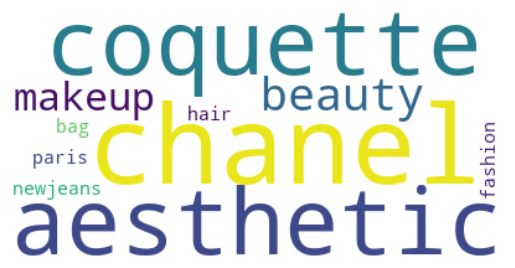

In [73]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(topic_model, topic):
    text = {word: value for word, value in topic_model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


create_wordcloud(bert_topic_model, topic=-1)